In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob, sys
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r"
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 12.0

In [2]:
t_scale=1200
dx_scale=3840e5/512

In [3]:
# set up mesh
import matplotlib.tri as tri
from dolfin import *
from qgm2_parameters import *
from scipy import interpolate

mesh = RectangleMesh(Point(0.0, 0.0), Point(L, L), ngrid, ngrid)
space = FunctionSpace(mesh, "CG", 1)
test, trial = TestFunction(space), TrialFunction(space)
zero_bcs = DirichletBC(space, 0.0, "on_boundary")

# some general reusable variables
x_vec, y_vec = np.meshgrid(np.linspace(0, L, ngrid+1), np.linspace(0, L, ngrid+1))
input_points = np.array([x_vec[:].flatten(), y_vec[:].flatten()]).T
output_points = mesh.coordinates()
triang = tri.Triangulation(output_points[:, 0], output_points[:, 1])

# for putting stuff onto mesh
dof_2_vert = dof_to_vertex_map(space)

# for moving stuff onto grid
vert_2_dof = vertex_to_dof_map(space)



def grid_to_mesh(grid_data, mesh_func):
    """Takes grid data and interpolates it onto a pre-defined finite element mesh"""
    for layer in range(len(mesh_func)):
        data_in = grid_data[layer,:,:]

        # interpolator = interpolate.LinearNDInterpolator(input_points, data_in[:].flatten())
        interpolator = interpolate.NearestNDInterpolator(input_points, data_in[:].flatten())  # much faster
        mesh_func[layer].vector()[:] = interpolator(output_points[dof_2_vert])
        
    return mesh_func

def mesh_to_grid(mesh_func, ny=ngrid+1, nx=ngrid+1):
    """Takes finite element function and pull out data onto regular grid
    
       This subtroutine exploits the fact that the mesh is structued and regular, so just do it
       with vertex_to_dof map. If not regular mesh, will need to write a probing routine,
       or cheat by pulling out vertices then constructing an interpolator.
    """
    layers = len(mesh_func)
    grid_data = np.zeros((layers, ny, nx))
    for l in range(layers):
        grid_data[l, :, :] = np.reshape(mesh_func[l].vector()[vert_2_dof], (ngrid+1, ngrid+1))
        
    return grid_data

finished loading qgm2_parameters


In [4]:
def cal_div(u,v):
    if u.shape[0] >512:
        u=u[:-1,:-1]
        v=v[:-1,:-1]
        
    uq_p1=np.zeros((3,513,513))
    uq_p1[0,:-1,:-1]=u[:,:]
    vq_p1=np.zeros((3,513,513))
    vq_p1[0,:-1,:-1]=v[:,:]
    
    uq_p_mesh=grid_to_mesh(uq_p1,[Function(space, name = "uq_p_%i" % (i + 1)) for i in range(layers)])
    vq_p_mesh=grid_to_mesh(vq_p1,[Function(space, name = "vq_p_%i" % (i + 1)) for i in range(layers)])
    
    div_uq00 = [Function(space, name = "div_uq_%i" % (i + 1)) for i in range(layers)]
    for l in range(layers):  
        Lt = (div(as_vector([uq_p_mesh[l], vq_p_mesh[l]])) - trial) * test * dx
        solve(lhs(Lt) == rhs(Lt), div_uq00[l])
        
    return mesh_to_grid(div_uq00)[0,:-1,:-1] # return [512,512]

# fig1

In [5]:
fn='empb'
fn_label='q'
nly=0
varn='psi'

In [6]:
scale_d=dx_scale/t_scale/t_scale
ff=np.load('../data/training/00/grad_%s_80.npz'%(fn))
gu=ff[ff.files[0]][nly]*scale_d/100
gv=ff[ff.files[1]][nly]*scale_d/100

scale_d=dx_scale/t_scale/t_scale
ff=np.load('../data/training/00/uvq_%s_80.npz'%(fn))
uq=ff[ff.files[0]][nly]*scale_d/100
vq=ff[ff.files[1]][nly]*scale_d/100

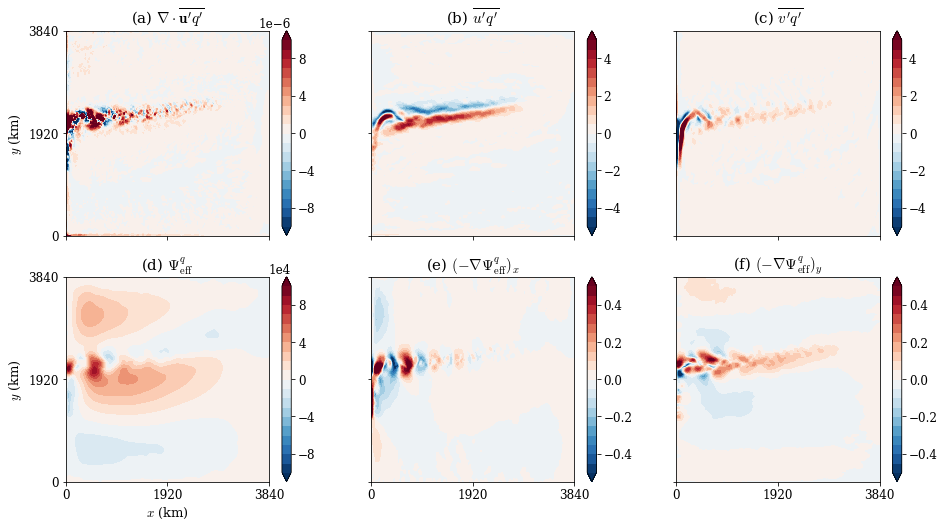

In [7]:
fig=plt.figure(figsize=(15.5,8.3))
lm=1.e-5 #30/t_scale/t_scale
ax=plt.subplot(231)
#plt.imshow(div[nly],origin='lower',vmax=lm,vmin=-lm)#
div_o=np.load("../data/training/00/div_uq_%s_80.npy"%(fn))/t_scale/t_scale
cs=plt.contourf(x_vec,y_vec,div_o[nly],levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
plt.colorbar(ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])
ax.set_rasterization_zorder(-1)
aa=plt.title(r"(a) $ \nabla \cdot \overline{\mathbf{u}' %s'} $"%(fn_label),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelbottom=False)
#plt.xlabel('km')
plt.ylabel(r"$y$ (km)",fontsize=13)

lm=5
ax=plt.subplot(232)
cs=plt.contourf(x_vec,y_vec,uq,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
plt.colorbar(ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])
ax.set_rasterization_zorder(-1)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelbottom=False,labelleft=False)
aa=plt.title(r"(b) $\overline{u' q'}$",fontsize=15)

ax=plt.subplot(233)
cs=plt.contourf(x_vec,y_vec,vq,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
plt.colorbar(ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])
ax.set_rasterization_zorder(-1)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelbottom=False,labelleft=False)
aa=plt.title(r"(c) $\overline{v' q'}$",fontsize=15)

lm=1e5
ax=plt.subplot(234)
ffd=np.load("../data/training/00/ffd_%s_80.npy"%(fn))*(dx_scale*dx_scale/t_scale/t_scale)/10000
cs=plt.contourf(x_vec,y_vec,ffd[nly],levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
plt.colorbar(ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])
ax.set_rasterization_zorder(-1)
aa=plt.title(r"(d) $ \Psi^{%s}_{\rm eff}$"%(fn_label),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xlabel(r"$x$ (km)",fontsize=13)
plt.ylabel(r"$y$ (km)",fontsize=13)

lm=.5
ax=plt.subplot(235)
cs=plt.contourf(x_vec,y_vec,-gu,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
plt.colorbar(ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])
ax.set_rasterization_zorder(-1)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelleft=False)
aa=plt.title(r"(e) $ ( -\nabla  \Psi^{%s}_{\rm eff} )_x$"%(fn_label),fontsize=15)

ax=plt.subplot(236)
cs=plt.contourf(x_vec,y_vec,-gv,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
plt.colorbar(ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])
ax.set_rasterization_zorder(-1)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelleft=False)
aa=plt.title(r"(f) $( -\nabla \Psi^{%s}_{\rm eff})_y$"%(fn_label),fontsize=15)

#fig.savefig('../image/Fig1.pdf',bbox_inches='tight',dpi=200)
#fig.savefig('../image/Fig1.png',bbox_inches='tight',dpi=200)

# Fig3&5 

In [8]:
fn='empb'
fn_label='q'

div_pr=np.load('../data/preds/00/%s/Pr_div_%s_00_%s_30.npy'%(nly,fn,varn))

In [9]:
ff=np.load('../data/preds/00/%s/Pr_grad_%s_00_%s_30.npz'%(nly,fn,varn))
gu=ff[ff.files[0]]
gv=ff[ff.files[1]]

div_grad_pr = cal_div(gu,gv)

In [10]:
scale_d=dx_scale/t_scale/t_scale
ff=np.load('../data/preds/00/%s/Pr_uvq_%s_00_%s_30.npz'%(nly,fn,varn))
uq=ff[ff.files[0]]
vq=ff[ff.files[1]]

div_uq_pr = cal_div(uq,vq)

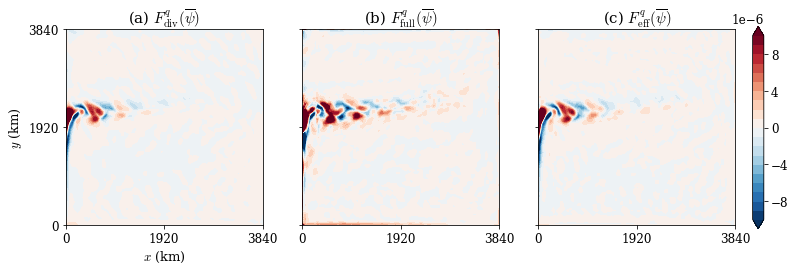

In [11]:
fig=plt.figure(figsize=(12,3.6))
lm=1.e-5
ax=plt.subplot(131)
cs=plt.contourf(x_vec,y_vec,div_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(a) $F^%s_{\rm div} (\overline{\psi}) $"%(fn_label),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
#plt.tick_params(labelbottom=False)
ax.set_rasterization_zorder(-1)
plt.xlabel(r'$x$ (km)',fontsize=13)
plt.ylabel(r'$y$ (km)',fontsize=13)

ax=plt.subplot(132)
cs=plt.contourf(div_uq_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(b) $F^%s_{\rm full} (\overline{\psi})$"%(fn_label),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(133)
cs=plt.contourf(-div_grad_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(c) $F^%s_{\rm eff} (\overline{\psi})$"%(fn_label),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelleft=False)
ax.set_rasterization_zorder(-1)

fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.11, 0.013, 0.78])
fig.colorbar(cs, cax=cbar_ax,ticks=[-8e-6,-4e-6, 0,4e-6, 8e-6])
#fig.savefig('../image/Fig3.pdf',bbox_inches='tight',dpi=200)
#fig.savefig('../image/Fig3.png',bbox_inches='tight',dpi=200)

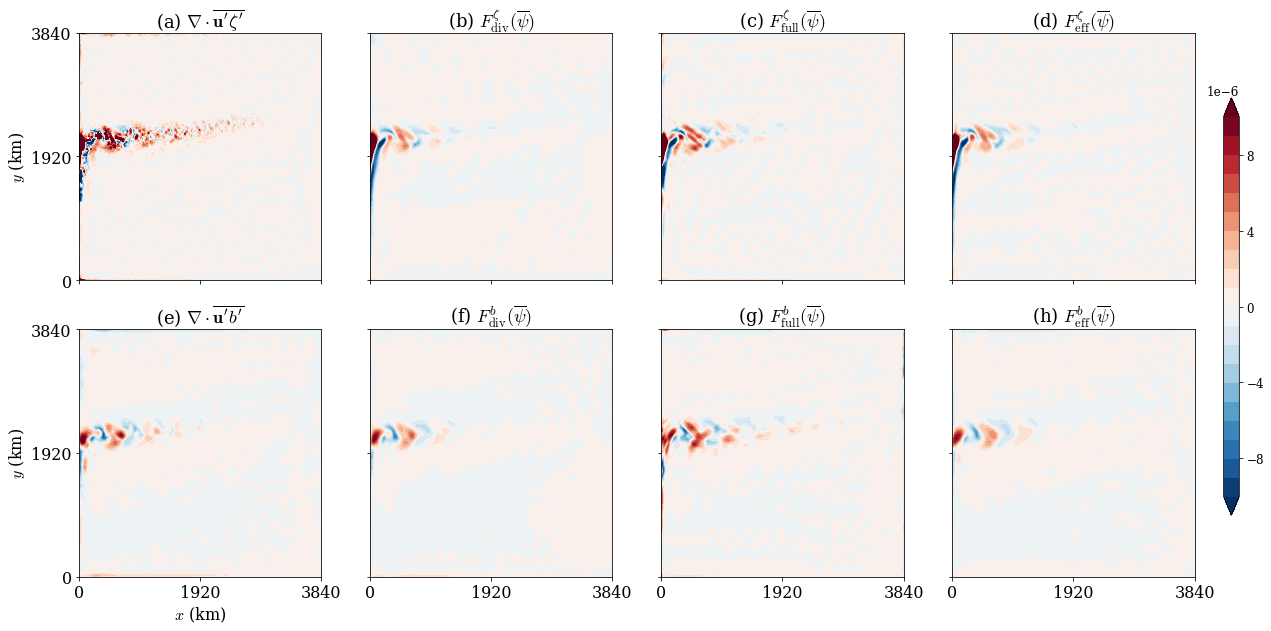

In [12]:
fig=plt.figure(figsize=(20,10))
fn_label="\zeta"
fn="em"
lm=1e-5 # 
ax=plt.subplot(241)
div_o=np.load('../data/training/00/div_uq_%s_80.npy'%(fn))/t_scale/t_scale
cs=plt.contourf(x_vec,y_vec,div_o[nly],levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(a) $\nabla \cdot \overline{\mathbf{u}' %s'} $"%(fn_label),fontsize=18)# b/\zeta
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False)
ax.set_rasterization_zorder(-1)
#plt.xlabel(r'$x$ (km)',fontsize=13)
plt.ylabel(r'$y$ (km)',fontsize=16)

ax=plt.subplot(242)
div_pr=np.load('../data/preds/00/%s/Pr_div_%s_00_%s_30.npy'%(nly,fn,varn))
cs=plt.contourf(x_vec,y_vec,div_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(b) $F^{%s}_{\rm div} (\overline{\psi}) $"%(fn_label),fontsize=18)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False,labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(243)
ff=np.load('../data/preds/00/%s/Pr_uvq_%s_00_%s_30.npz'%(nly,fn,varn))
uq=ff[ff.files[0]]
vq=ff[ff.files[1]]

div_uq_pr = cal_div(uq,vq)
cs=plt.contourf(div_uq_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(c) $F^{%s}_{\rm full} (\overline{\psi})$"%(fn_label),fontsize=18)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False,labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(244)
ff=np.load('../data/preds/00/%s/Pr_grad_%s_00_%s_30.npz'%(nly,fn,varn))
gu=ff[ff.files[0]]
gv=ff[ff.files[1]]

div_grad_pr = cal_div(gu,gv)
cs=plt.contourf(-div_grad_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(d) $F^{%s}_{\rm eff} (\overline{\psi})$"%(fn_label),fontsize=18)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False,labelleft=False)
ax.set_rasterization_zorder(-1)


fn_label='b'
fn='eb'
#lm=.5e-5 
ax=plt.subplot(245)
div_o=np.load('../data/training/00/div_uq_%s_80.npy'%(fn))/t_scale/t_scale
cs=plt.contourf(x_vec,y_vec,div_o[nly],levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(e) $\nabla \cdot \overline{\mathbf{u}' %s'} $"%(fn_label),fontsize=18)# b/\zeta
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
#plt.tick_params(labelbottom=False)
ax.set_rasterization_zorder(-1)
plt.xlabel(r'$x$ (km)',fontsize=16)
plt.ylabel(r'$y$ (km)',fontsize=16)

ax=plt.subplot(246)
div_pr=np.load('../data/preds/00/%s/Pr_div_%s_00_%s_30.npy'%(nly,fn,varn))
cs=plt.contourf(x_vec,y_vec,div_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(f) $F^{%s}_{\rm div} (\overline{\psi}) $"%(fn_label),fontsize=18)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(247)
ff=np.load('../data/preds/00/%s/Pr_uvq_%s_00_%s_30.npz'%(nly,fn,varn))
uq=ff[ff.files[0]]
vq=ff[ff.files[1]]

div_uq_pr = cal_div(uq,vq)
cs=plt.contourf(div_uq_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(g) $F^{%s}_{\rm full} (\overline{\psi})$"%(fn_label),fontsize=18)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(248)
ff=np.load('../data/preds/00/%s/Pr_grad_%s_00_%s_30.npz'%(nly,fn,varn))
gu=ff[ff.files[0]]
gv=ff[ff.files[1]]

div_grad_pr = cal_div(gu,gv)
cs=plt.contourf(-div_grad_pr/t_scale/t_scale,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(h) $F^{%s}_{\rm eff} (\overline{\psi})$"%(fn_label),fontsize=18)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelleft=False)
ax.set_rasterization_zorder(-1)

fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.21, 0.011, 0.58])
fig.colorbar(cs, cax=cbar_ax,ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])

#fig.savefig('../image/Fig5.pdf',bbox_inches='tight',dpi=200)
#fig.savefig('../image/Fig5.png',bbox_inches='tight',dpi=200)

# Fig4 & 6

firstly generate csv files for 20 menbers from "for_plot_20members.py"

In [14]:
import pandas as pd
import seaborn as sns

In [15]:
df=pd.read_csv('../data/for_plot/l2_00_paper.csv',header=None)
df.set_axis(['L2','l2','H1/2','h1/2','f3', 'v', 'e3','p5','r'], axis=1, inplace=True)

In [16]:
df

,L2,l2,H1/2,h1/2,f3,v,e3,p5,r
0,1.168342e+06,0.558737,45871.936579,0.414741,empb,psi,div,6400,30
1,1.245622e+06,0.576920,47169.963296,0.420568,empb,psi,div,6400,31
2,1.439734e+06,0.620245,61636.764398,0.480754,empb,psi,div,6400,32
3,1.527277e+06,0.638824,66137.955550,0.497999,empb,psi,div,6400,33
4,1.317387e+06,0.593307,51079.744714,0.437650,empb,psi,div,6400,34
...,...,...,...,...,...,...,...,...,...
535,1.068996e+05,0.628609,4687.525718,0.431087,eb,rel,grad,6400,45
536,9.000704e+04,0.576807,4962.983765,0.443572,eb,rel,grad,6400,46
537,8.067402e+04,0.546084,4721.975847,0.432668,eb,rel,grad,6400,47
538,8.376147e+04,0.556435,5056.906649,0.447750,eb,rel,grad,6400,48


In [17]:
x_labels= ['$\overline{\psi}$','$\overline{q}$','$\overline{\zeta}$']#,'$eke$'
x_la0=[r'$F^q_{\rm div}(\overline{\psi})$',r'$F^q_{\rm full}(\overline{\psi})$',
      r'$F^q_{\rm eff}(\overline{\psi})$']

In [18]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

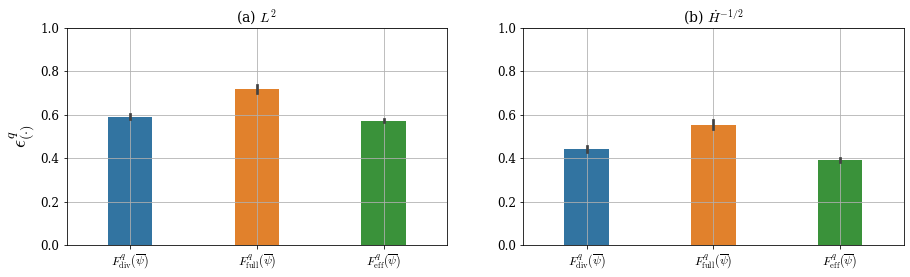

In [19]:
hue_order = ['div', 'uvq', 'grad']
fig=plt.figure(figsize=(15,4))
plt.subplot(121)
ax = sns.barplot(x='e3',y="l2",data=df.loc[(df["f3"] == "empb")&(df["v"] == "psi")],order=hue_order)#, capsize=.008
plt.ylabel(r'$\epsilon ^q_{(\cdot)}$',fontsize=20)
#ax.set_xticklabels(x_,fontsize=12)
ax.set_ylim(0,1)
aa=plt.xticks(np.arange(3), x_la0,fontsize=12)

ax.set(xlabel=None)
change_width(ax, .35)
plt.grid()
aa=plt.title(r"(a) $L^2$",fontsize=14)

plt.subplot(122)
ax = sns.barplot(x='e3',y="h1/2",data=df.loc[(df["f3"] == "empb")&(df["v"] == "psi")],order=hue_order)#, capsize=.008
#ax.set_xticklabels(x_,fontsize=12)
plt.ylim(0,1)
aa=plt.xticks(np.arange(3), x_la0,fontsize=12)
plt.title(r"(b) $\dot{H}^{-1/2}$",fontsize=14)
ax.set(xlabel=None)
ax.set(ylabel=None)
change_width(ax, .35)
plt.grid()
#fig.savefig('../image/Fig4.pdf',  bbox_inches='tight',dpi=200)
#fig.savefig('../image/Fig4.png',  bbox_inches='tight',dpi=200)

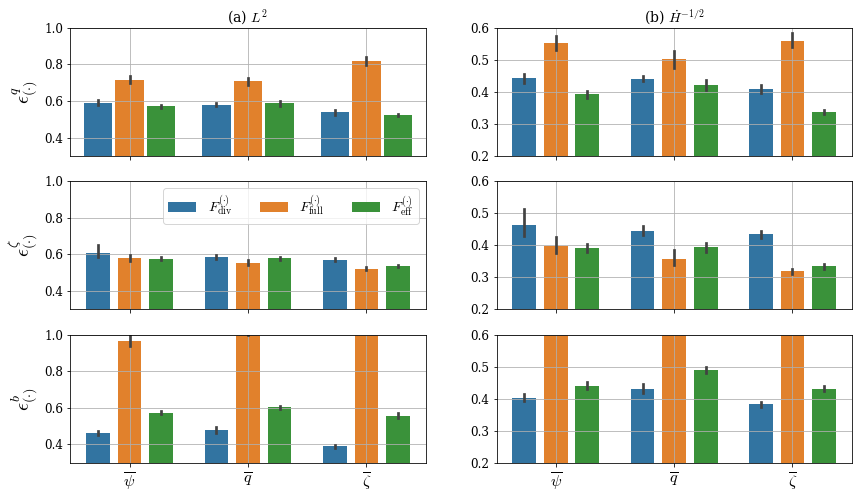

In [20]:
hue_order = ['div', 'uvq', 'grad']
fig=plt.figure(figsize=(14,8))
plt.subplot(321)
ax = sns.barplot(x="v", y="l2", hue="e3", data=df.loc[(df["f3"] == "empb")],hue_order=hue_order)
change_width(ax, .24)  
ax.get_legend().remove()
    
plt.ylim(0.3,1)
plt.tick_params(labelbottom=False)
plt.ylabel(r'$\epsilon ^q_{(\cdot)}$',fontsize=20)
ax.set(xlabel=None)
plt.grid()
plt.title(r"(a) $L^2$",fontsize=14)

plt.subplot(323)
ax = sns.barplot(x="v", y="l2", hue="e3", data=df.loc[(df["f3"] == "em")],hue_order=hue_order)
change_width(ax, .2)  
#plt.legend(ncol=3)
ax.legend(ncol=3,fontsize=14)
g = ax.get_legend()
g.set_title([])
for t, l in zip(g.texts, [r'$F^{(\cdot)}_{\rm div}$',r'$F^{(\cdot)}_{\rm full}$',r'$F^{(\cdot)}_{\rm eff}$']):
    t.set_text(l)

plt.ylim(0.3,1)
plt.tick_params(labelbottom=False)
plt.ylabel(r'$\epsilon ^{\zeta}_{(\cdot)}$',fontsize=20)

ax.set(xlabel=None)
plt.grid()

plt.subplot(325)
ax = sns.barplot(x="v", y="l2", hue="e3", data=df.loc[(df["f3"] == "eb")],hue_order=hue_order)
change_width(ax, .2)  
#plt.legend(ncol=3)
ax.get_legend().remove()
plt.ylim(0.3,1)
plt.ylabel(r'$\epsilon ^b_{(\cdot)}$',fontsize=20)
ax.set(xlabel=None)
plt.grid()

aa=plt.xticks(np.arange(3), x_labels[:],fontsize=16)

plt.subplot(322)
plt.title(r"(b) $\dot{H}^{-1/2}$",fontsize=14)
ax = sns.barplot(x="v", y="h1/2", hue="e3", data=df.loc[(df["f3"] == "empb")],hue_order=hue_order)
change_width(ax, .20)  
ax.get_legend().remove()   
plt.ylim(0.2,.6)
plt.tick_params(labelbottom=False)
#plt.ylabel(r'$\Vert \nabla \cdot \overline{\mathbf{u}^{\prime} q^{\prime}}- F^q_{(\cdot)} (\cdot) \Vert^2_{\dot{H}^{-1/2}} $',
#           fontsize=14)
ax.set(ylabel=None)
ax.set(xlabel=None)
plt.grid()

plt.subplot(324)
ax = sns.barplot(x="v", y="h1/2", hue="e3", data=df.loc[(df["f3"] == "em")],hue_order=hue_order)
change_width(ax, .2)  
ax.get_legend().remove()
plt.ylim(0.2,.6)
plt.tick_params(labelbottom=False)
ax.set(ylabel=None)
ax.set(xlabel=None)
plt.grid()

plt.subplot(326)
ax = sns.barplot(x="v", y="h1/2", hue="e3", data=df.loc[(df["f3"] == "eb")],hue_order=hue_order)
change_width(ax, .2)  
#plt.legend(ncol=3)
ax.get_legend().remove()
plt.ylim(0.2,.6)
ax.set(ylabel=None)
ax.set(xlabel=None)
plt.grid()
aa=plt.xticks(np.arange(3), x_labels[:],fontsize=16)

#fig.savefig('../image/Fig6.pdf',  bbox_inches='tight',dpi=200)
#fig.savefig('../image/Fig6.png',  bbox_inches='tight',dpi=200)

# Fig 7

In [21]:
df1=df.loc[(df["v"] == "psi")]
df1['n']=0
df1

<ipython-input-21-17a29d0c55a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['n']=0


,L2,l2,H1/2,h1/2,f3,v,e3,p5,r,n
0,1.168342e+06,0.558737,45871.936579,0.414741,empb,psi,div,6400,30,0
1,1.245622e+06,0.576920,47169.963296,0.420568,empb,psi,div,6400,31,0
2,1.439734e+06,0.620245,61636.764398,0.480754,empb,psi,div,6400,32,0
3,1.527277e+06,0.638824,66137.955550,0.497999,empb,psi,div,6400,33,0
4,1.317387e+06,0.593307,51079.744714,0.437650,empb,psi,div,6400,34,0
...,...,...,...,...,...,...,...,...,...,...
495,8.626489e+04,0.564689,4214.445272,0.408755,eb,psi,grad,6400,45,0
496,8.515016e+04,0.561029,4613.861080,0.427686,eb,psi,grad,6400,46,0
497,8.000791e+04,0.543825,4137.915991,0.405027,eb,psi,grad,6400,47,0
498,8.429330e+04,0.558199,4450.287021,0.420036,eb,psi,grad,6400,48,0


In [22]:
df2=pd.read_csv('../data/for_plot/l2_00_noise_psi.csv',header=None)
df2.set_axis(['L2','l2','H1/2','h1/2','f3', 'v', 'e3','p5','r','n'], axis=1, inplace=True)

In [23]:
df_noise=pd.concat([df1,df2], ignore_index=True)
df_noise['n']=df_noise['n']*.1
df_noise

,L2,l2,H1/2,h1/2,f3,v,e3,p5,r,n
0,1.168342e+06,0.558737,45871.936579,0.414741,empb,psi,div,6400,30,0.0
1,1.245622e+06,0.576920,47169.963296,0.420568,empb,psi,div,6400,31,0.0
2,1.439734e+06,0.620245,61636.764398,0.480754,empb,psi,div,6400,32,0.0
3,1.527277e+06,0.638824,66137.955550,0.497999,empb,psi,div,6400,33,0.0
4,1.317387e+06,0.593307,51079.744714,0.437650,empb,psi,div,6400,34,0.0
...,...,...,...,...,...,...,...,...,...,...
895,1.136609e+05,0.648184,6488.522977,0.507184,eb,psi,grad,6400,45,1.2
896,9.923068e+04,0.605641,5151.552537,0.451920,eb,psi,grad,6400,46,1.2
897,1.045064e+05,0.621532,5704.538334,0.475557,eb,psi,grad,6400,47,1.2
898,1.008717e+05,0.610629,5166.451436,0.452573,eb,psi,grad,6400,48,1.2


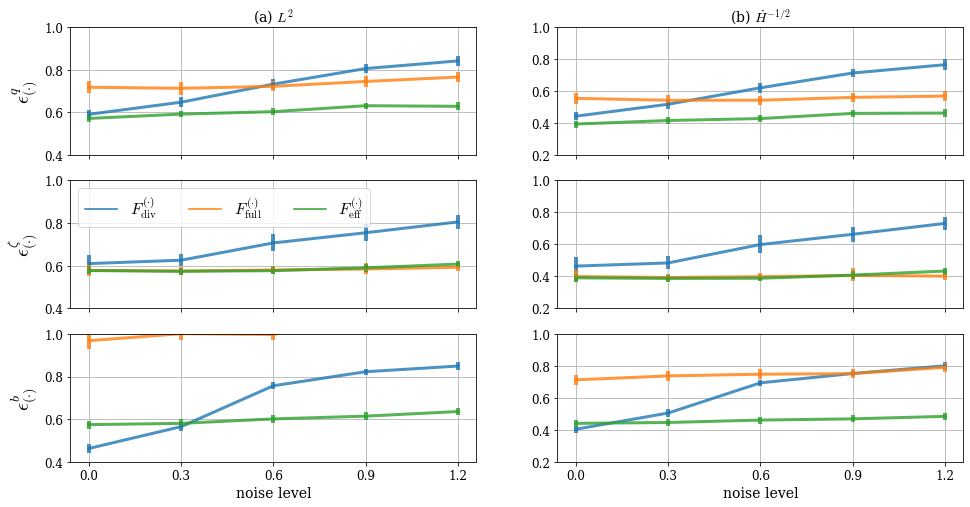

In [24]:
hue_order = ['div','uvq', 'grad']
fig=plt.figure(figsize=(16,8))
plt.subplot(321)
ax = sns.lineplot(x='n',y="l2", hue='e3',data=df_noise.loc[(df_noise["f3"] == "empb")&(df_noise["v"] == "psi")],
                  linewidth = 3,alpha = 0.8,err_style='bars',hue_order=hue_order,err_kws={'elinewidth':4})
plt.ylabel(r'$\epsilon^{q}_{(\cdot)} $', fontsize=20)
ax.get_legend().remove()
ax.set(xlabel=None)
aa=plt.xticks([0.0,0.3,0.6,0.9,1.2])
ax.set_xticklabels([])
plt.ylim(0.4,1)
plt.grid()
aa=plt.title(r"(a) $L^2$",fontsize=14)

plt.subplot(323)
ax = sns.lineplot(x='n',y="l2", hue='e3',data=df_noise.loc[(df_noise["f3"] == "em")&(df_noise["v"] == "psi")],
                  linewidth = 3,alpha = 0.8, err_style='bars',hue_order=hue_order,err_kws={'elinewidth':4})
plt.ylabel(r'$\Vert \nabla \cdot \overline{\mathbf{u}^{\prime} \zeta^{\prime}}- F^m_{(\cdot)} (\cdot) \Vert^2_{L^2} $',
           fontsize=14)

ax.legend(ncol=3,fontsize=16)
g = ax.get_legend()
g.set_title([])
for t, l in zip(g.texts, [r'$F^{(\cdot)}_{\rm div}$',r'$F^{(\cdot)}_{\rm full}$',r'$F^{(\cdot)}_{\rm eff}$']):
    t.set_text(l)
g.set_title([])
plt.ylabel(r'$\epsilon^{\zeta}_{(\cdot)} $', fontsize=20)
ax.set(xlabel=None)
aa=plt.xticks([0.0,0.3,0.6,0.9,1.2])
ax.set_xticklabels([])
plt.ylim(0.4,1)

plt.grid()

plt.subplot(325)
ax = sns.lineplot(x='n',y="l2", hue='e3',data=df_noise.loc[(df_noise["f3"] == "eb")&(df_noise["v"] == "psi")],
                  linewidth = 3,alpha = 0.8,err_style='bars',hue_order=hue_order,err_kws={'elinewidth':4})
plt.ylabel(r'$\epsilon^{b}_{(\cdot)} $', fontsize=20)
ax.get_legend().remove()
#ax.set(xlabel=None)
ax.set_xlabel('noise level',fontsize=14)
plt.ylim(0.4,1)
aa=plt.xticks([0.0,0.3,0.6,0.9,1.2])
plt.grid()


plt.subplot(322)
plt.title(r"(b) $\dot{H}^{-1/2}$",fontsize=14)
ax = sns.lineplot(x='n',y="h1/2", hue='e3',data=df_noise.loc[(df_noise["f3"] == "empb")&(df_noise["v"] == "psi")],
                  linewidth = 3,alpha = 0.8,err_style='bars',hue_order=hue_order,err_kws={'elinewidth':4})
ax.set(ylabel=None)
ax.get_legend().remove()
ax.set(xlabel=None)
aa=plt.xticks([0.0,0.3,0.6,0.9,1.2])
ax.set_xticklabels([])
plt.ylim(0.2,1)
plt.grid()

plt.subplot(324)
ax = sns.lineplot(x='n',y="h1/2", hue='e3',data=df_noise.loc[(df_noise["f3"] == "em")&(df_noise["v"] == "psi")],
                  linewidth = 3,alpha = 0.8,err_style='bars',hue_order=hue_order,err_kws={'elinewidth':4})
plt.ylabel(r'$\Vert \nabla \cdot \overline{\mathbf{u}^{\prime} \zeta^{\prime}}- F^m_{(\cdot)} (\cdot) \Vert^2_{L^2} $',
           fontsize=14)

ax.get_legend().remove()
g.set_title([])
ax.set(ylabel=None)
ax.set(xlabel=None)
aa=plt.xticks([0.0,0.3,0.6,0.9,1.2])
ax.set_xticklabels([])
plt.ylim(0.2,1)
plt.grid()

plt.subplot(326)
ax = sns.lineplot(x='n',y="h1/2", hue='e3',data=df_noise.loc[(df_noise["f3"] == "eb")&(df_noise["v"] == "psi")],
                  linewidth = 3,alpha = 0.8,err_style='bars',hue_order=hue_order,err_kws={'elinewidth':4})
ax.set(ylabel=None)
ax.get_legend().remove()
#ax.set(xlabel=None)
ax.set_xlabel('noise level',fontsize=14)
aa=plt.xticks([0.0,0.3,0.6,0.9,1.2])
plt.ylim(0.2,1)

plt.grid()

#fig.savefig('../image/Fig7.pdf',  bbox_inches='tight',dpi=200)
#fig.savefig('../image/Fig7.png',  bbox_inches='tight',dpi=200)